In [49]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [55]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [56]:
tickerSymbol = 'Apexfoot'

In [57]:
# Load the CSV file into a DataFrame
df = pd.read_csv('C:/Users/Developer/pythonProject/breakout_test/stock_data_saport.csv')

# Convert the date column to a datetime data type
df['Date'] = pd.to_datetime(df['Date'])

# Set the Date column as the index
df.set_index('Date', inplace=True)

In [70]:
# Define the date range
start_date = '2023-01-01'
end_date = '2023-02-23'


In [71]:
# Get the historical data for the specified date range
history_data = df.loc[start_date:end_date]
prices = history_data.Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

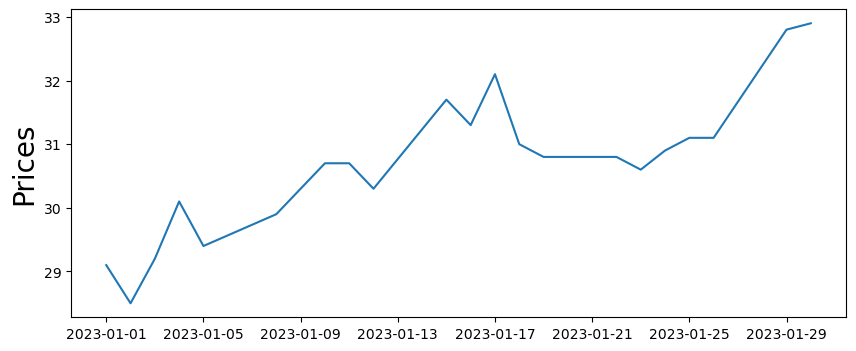

In [72]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

(array([19358., 19362., 19366., 19370., 19374., 19378., 19382., 19386.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

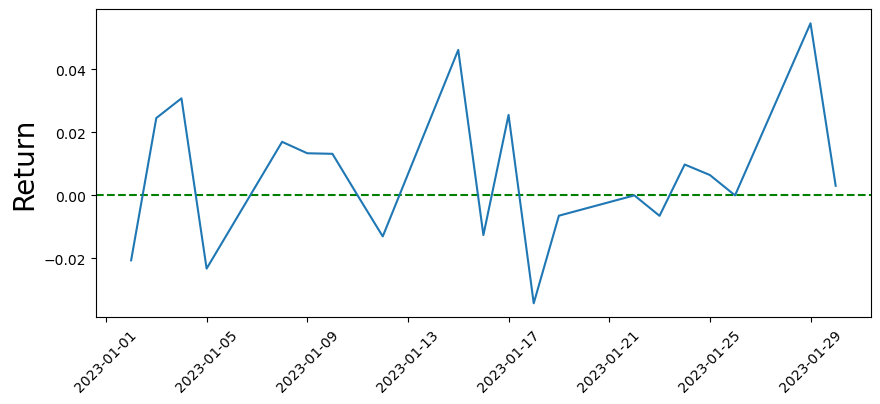

In [73]:
plt.figure(figsize=(10,4))
plt.axhline(y=0, color='green', linestyle='--')
plt.plot(returns)
plt.ylabel('Return', fontsize=20)
plt.xticks(rotation=45)

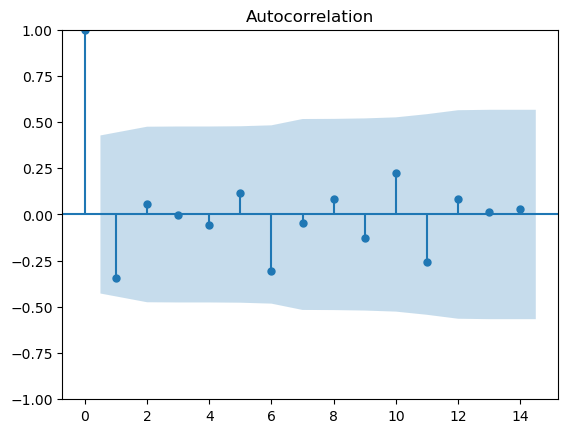

In [74]:
plot_acf(returns)
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 14 must be < 10.

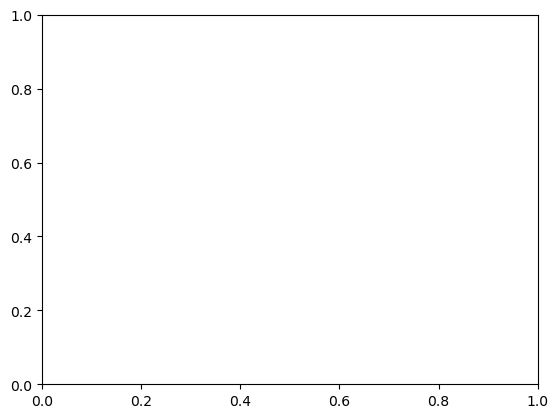

In [75]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying

100%|██████████| 7/7 [00:00<?, ?it/s]


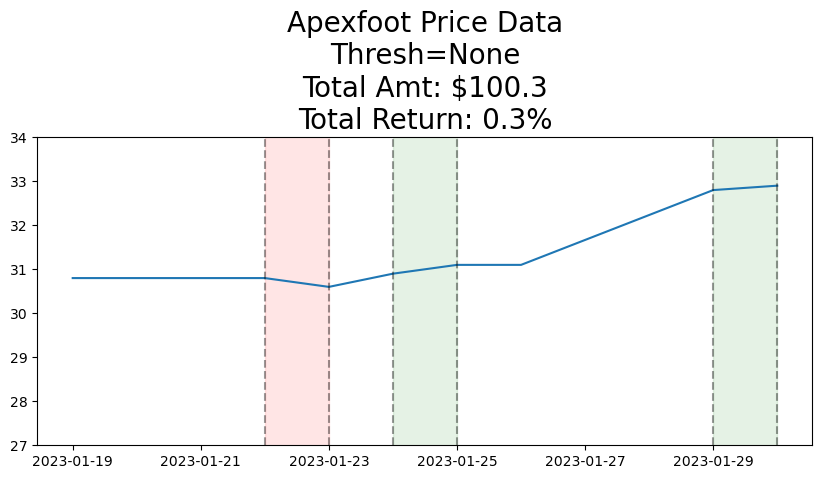

100.29855445288791

In [76]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [77]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 7/7 [00:00<00:00, 448.05it/s]


Text(0.5, 1.0, 'Avg: $102.13\nSD: $2.64')

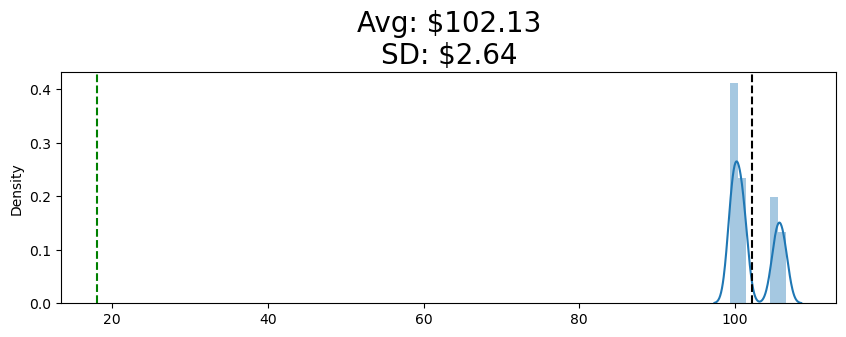

In [78]:
plt.figure(figsize=(10,3))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(18, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|██████████| 7/7 [00:00<00:00, 448.04it/s]


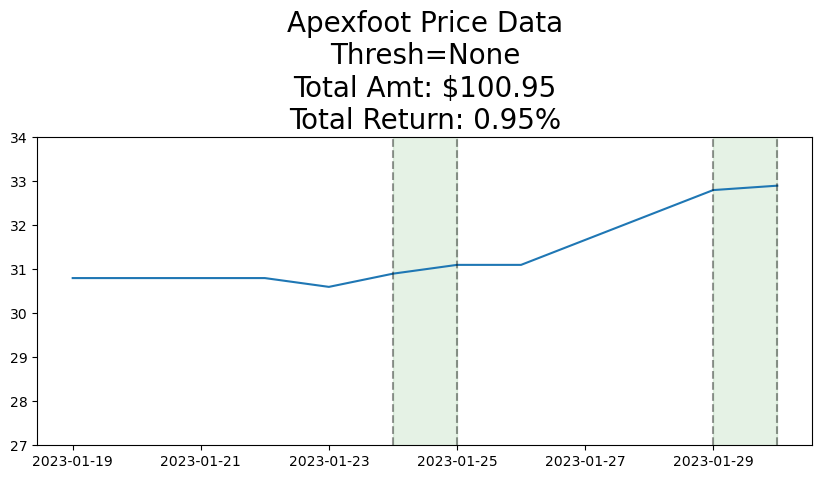

100.9541005604231

In [79]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)


# Try AR(1) Model

100%|██████████| 68/68 [00:00<?, ?it/s]


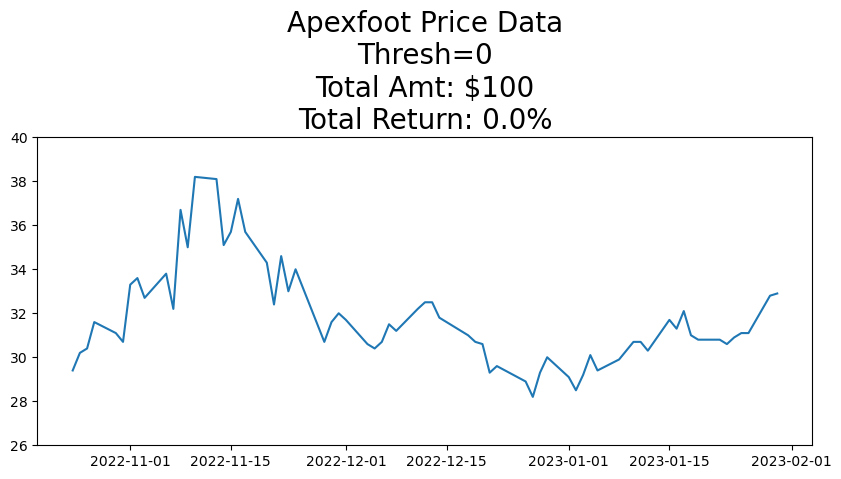

100%|██████████| 68/68 [00:00<00:00, 4351.27it/s]


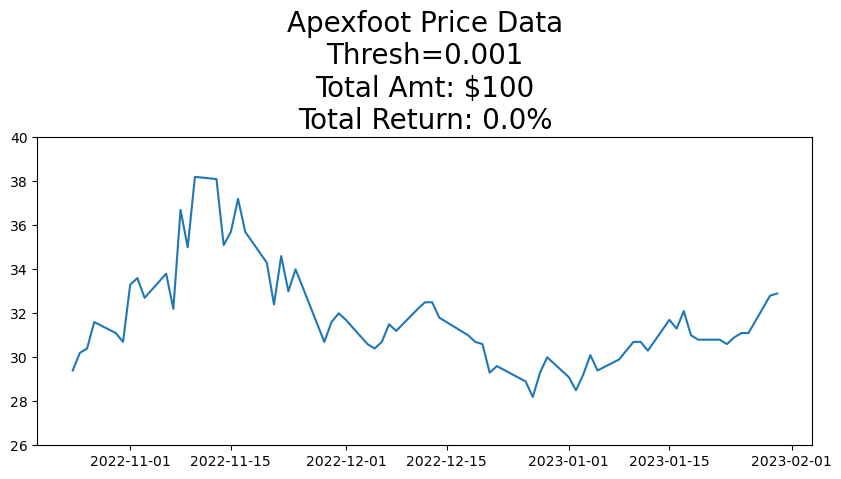

100%|██████████| 68/68 [00:00<?, ?it/s]


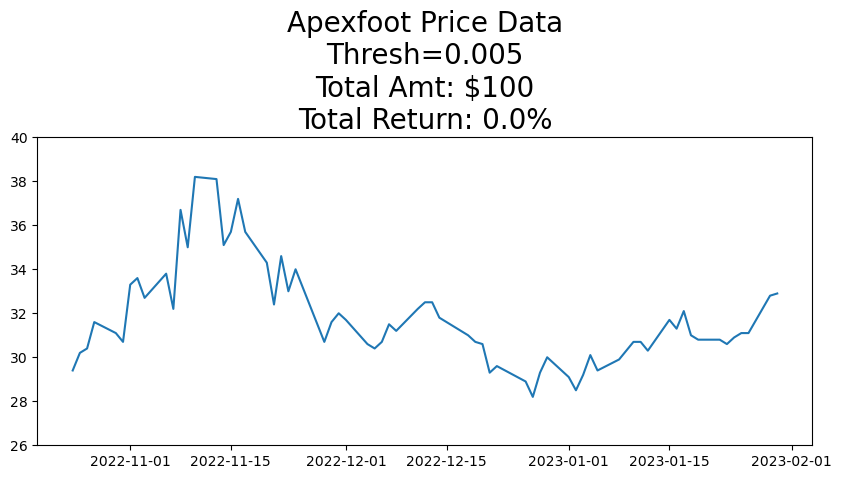

In [68]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(5) Model

100%|██████████| 68/68 [00:00<?, ?it/s]


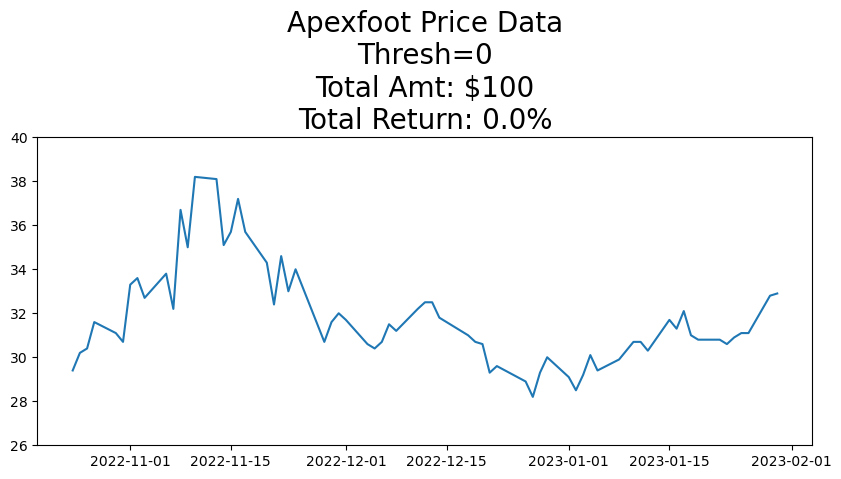

100%|██████████| 68/68 [00:00<00:00, 4351.20it/s]


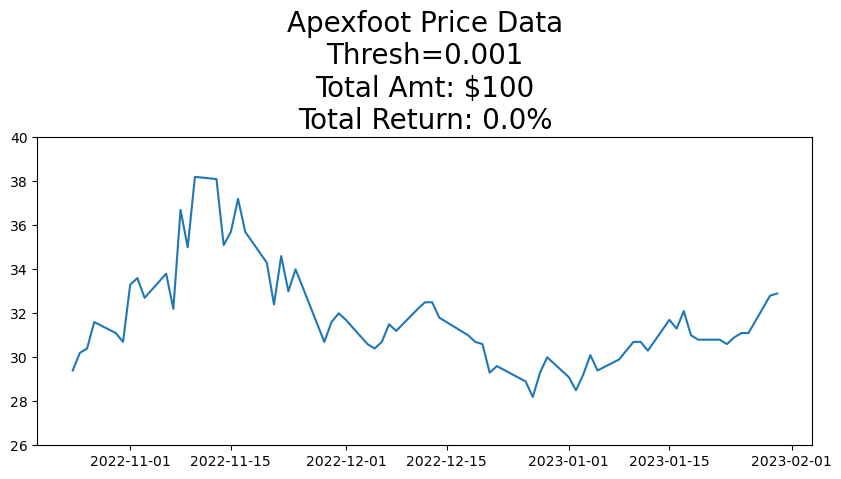

100%|██████████| 68/68 [00:00<00:00, 8461.53it/s]


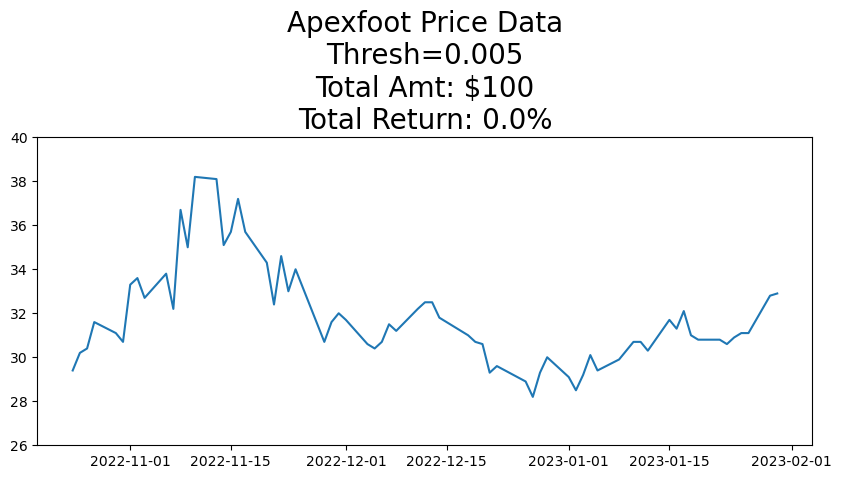

In [69]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

100%|██████████| 24/24 [00:00<?, ?it/s]


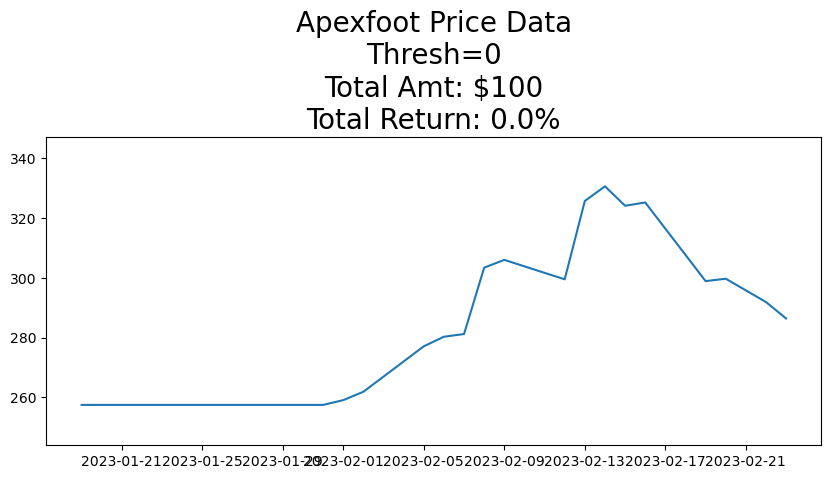

100%|██████████| 24/24 [00:00<?, ?it/s]


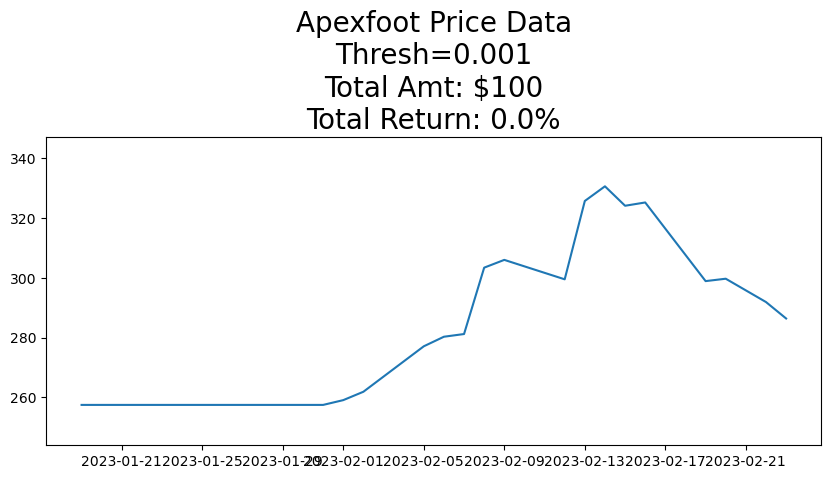

100%|██████████| 24/24 [00:00<?, ?it/s]


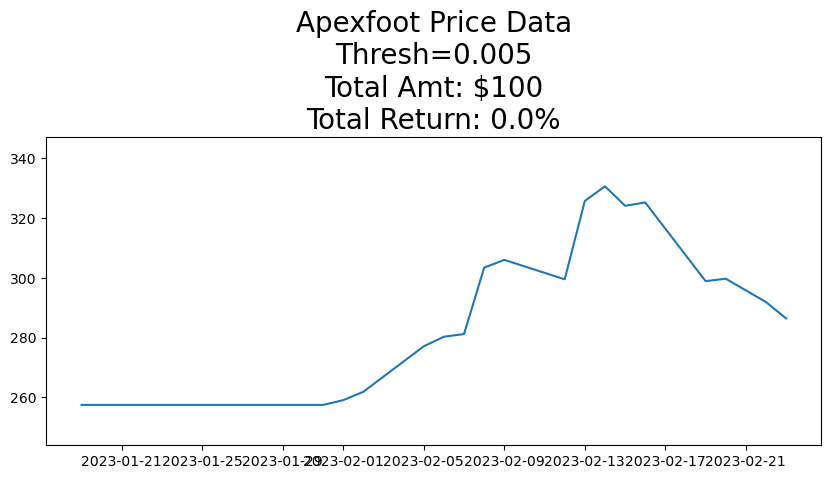

In [55]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)